In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import segmentation_models as sm

sys.path.append(os.path.abspath(".."))

from src.utils import rle_decode 
from src.model import get_unet_resnet50

2025-12-24 18:58:31.144200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766599111.159217   14929 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766599111.163740   14929 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-24 18:58:31.179279: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `tf.keras` framework.


In [2]:
physical_devices= tf.config.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
tf.config.set_visible_devices(physical_devices[0], 'GPU') # Uso gpu 0

In [4]:
PATH_CSV = '../data/train_ship_segmentations_v2.csv'
PATH_TRAIN = '../data/train_v2/'

In [5]:
df = pd.read_csv(PATH_CSV)

In [6]:
# Filtramos imágenes con barcos y creamos el conteo
df_with_ships = df.dropna(subset=['EncodedPixels'])
ship_table = df_with_ships.groupby('ImageId').size().reset_index(name='num_ships')
ship_table = ship_table.sort_values(by='num_ships', ascending=False).reset_index(drop=True)

print(f"Total de imágenes con barcos para entrenar: {len(ship_table)}")

Total de imágenes con barcos para entrenar: 42556


In [7]:
preprocess_input = sm.get_preprocessing('resnet50')

In [8]:
def data_generator(dataframe, batch_size=4):
    while True:
        batch_df = dataframe.sample(batch_size)
        images_pre, images_raw, masks = [], [], []
        
        for img_id in batch_df['ImageId']:
            img = cv2.imread(os.path.join(PATH_TRAIN, img_id))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_raw = img.astype('float32') / 255.0
            
            img_pre = preprocess_input(img.astype('float32'))
            
            all_rles = df[df['ImageId'] == img_id]['EncodedPixels'].values
            mask = np.zeros((768, 768, 1), dtype='float32')
            for rle in all_rles:
                if isinstance(rle, str):
                    mask[:, :, 0] += rle_decode(rle)
            
            # 2. Añadimos a las listas correctas
            images_pre.append(img_pre)
            images_raw.append(img_raw)
            masks.append(np.clip(mask, 0, 1).astype('float32'))
            
        yield np.array(images_pre), np.array(masks), np.array(images_raw)

In [9]:
# Inicializar modelo desde tu archivo model.py
#model = get_unet_resnet50()

#model.compile(
#    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#    loss=sm.losses.bce_dice_loss,
#    metrics=[sm.metrics.iou_score]
#)

# Entrenamiento de prueba
# train_gen = data_generator(ship_table, batch_size=4)
# model.fit(train_gen, steps_per_epoch=20, epochs=3)

In [10]:
train_gen = data_generator(ship_table, batch_size=4)

In [11]:
def visualizar_resultados(modelo_ia, generador, num=3):
    img_pre_batch, mask_batch, img_raw_batch = next(generador)
    
    preds = modelo_ia.predict(img_pre_batch)
    
    plt.figure(figsize=(15, 5 * num))
    for i in range(num):
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow(img_raw_batch[i])
        plt.title("Original (Visible)")
        
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow(mask_batch[i,:,:,0], cmap='gray')
        plt.title("Real")
        
        plt.subplot(num, 3, i*3 + 3)
        plt.imshow(preds[i,:,:,0] > 0.5, cmap='gray')
        plt.title("Predicción (U-Net)")
    plt.show()

In [12]:
#Enseñar resultados del modelo

In [13]:
model = get_unet_resnet50()

I0000 00:00:1766599115.167046   14929 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10532 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [14]:
model.load_weights('mejor_modelo.h5')

I0000 00:00:1766599119.087763   14962 service.cc:148] XLA service 0x7f5c840028b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766599119.087783   14962 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-12-24 18:58:39.175995: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1766599119.622322   14962 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-12-24 18:58:41.116012: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-12-24 18:58:41.885970: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


I0000 00:00:1766599130.746452   14962 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


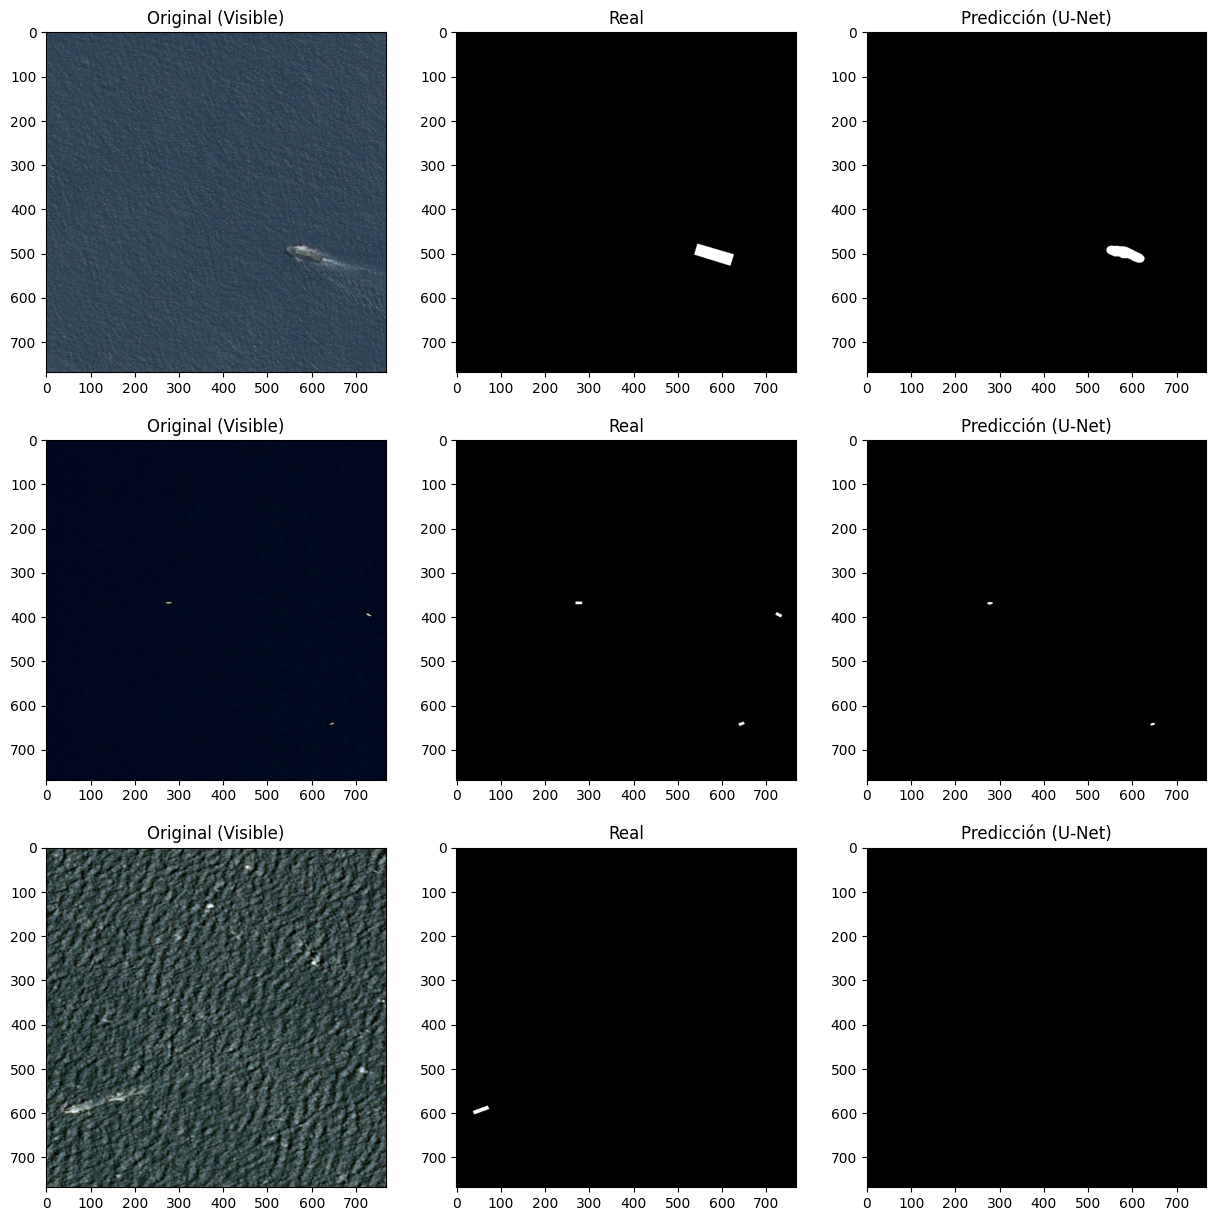

In [15]:
visualizar_resultados(model, train_gen)